In [17]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Keras
import tensorflow.keras as keras
import tensorflow as tf


# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [4]:
# Load the level 2 asteroid data
core_path = "../asteroid_taxonomy"
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))


In [5]:
# Allocate the spectra to one array and the classes to another one and expand dimensions Convulational network
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

asteroids_X = np.expand_dims(asteroids_X, axis=2)

In [6]:
# one hot encoder for probabilities, label encoding, and simple stratified shuffling split
# LOOC may be computationally expensive
label_encoder = preprocessing.OneHotEncoder(sparse_output=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

# how are things encoded list rotation by k index# handling imbalanced datasets

from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

# In this example we create a single test-training split with a ratio of 0.8 / 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [7]:
# handling imbalanced datasets version sklearn instead of manual weights

from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [9]:
# create_model and callback early stopping
import keras_tuner as kt

# Early Stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# We move our normalizer layers outside of the function every rows
normalizer = keras.layers.Normalization(axis=1)
normalizer.adapt(X_train)

W0000 00:00:1732549647.235829  560301 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# creating the model for training with dropout for extra fine tuning

def create_model(hp):

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    norm_layer = normalizer(input_layer)


    hidden_layer = keras.layers.Conv1D(filters=hp.Int("1st_filters",
                                                      min_value=8,
                                                      max_value=32,
                                                      step=8),
                                       activation="relu",
                                       kernel_size=hp.Int("1st_kernel_size",
                                                          min_value=3,
                                                          max_value=7,
                                                          step=1))(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Conv1D(filters=hp.Int("2nd_filters",
                                                      min_value=16,
                                                      max_value=128,
                                                      step=16),
                                       activation="relu",
                                       kernel_size=hp.Int("2nd_kernel_size",
                                                          min_value=3,
                                                          max_value=7,
                                                          step=1))(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Flatten()(hidden_layer)
    hidden_layer = keras.layers.Dense(hp.Int("units", min_value=8, max_value=64, step=8),
                                      activation="relu")(hidden_layer)

    if hp.Boolean("dropout"):
        hidden_layer = keras.layers.Dropout(hp.Float("dr_rate",
                                                     min_value=0.1,
                                                     max_value=0.5,
                                                     step=0.1))(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model

In [11]:
# tuner and optimizie the val_loss search
tuner  = kt.RandomSearch(create_model,
                         objective="val_loss",
                         max_trials=25)

end_epoch = 400
batch_size = 64

# searching for a best solution now
tuner.search(X_train,
             y_train,
             batch_size=batch_size,
             verbose=0,
             validation_split=0.25, epochs=end_epoch,
             sample_weight=sample_weight,
             callbacks=[es_callback])

model = tuner.get_best_models()[0]

/home/astavak/.pyenv/versions/3.11.0/envs/venv3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
1st_filters: 24
1st_kernel_size: 5
2nd_filters: 80
2nd_kernel_size: 5
units: 16
dropout: False
dr_rate: 0.1
Score: 0.028088264167308807

Trial 24 summary
Hyperparameters:
1st_filters: 8
1st_kernel_size: 6
2nd_filters: 96
2nd_kernel_size: 4
units: 24
dropout: False
dr_rate: 0.1
Score: 0.02979143336415291

Trial 16 summary
Hyperparameters:
1st_filters: 16
1st_kernel_size: 3
2nd_filters: 112
2nd_kernel_size: 5
units: 56
dropout: True
dr_rate: 0.1
Score: 0.030772365629673004

Trial 04 summary
Hyperparameters:
1st_filters: 16
1st_kernel_size: 6
2nd_filters: 128
2nd_kernel_size: 3
units: 40
dropout: False
dr_rate: 0.5
Score: 0.0333574153482914

Trial 19 summary
Hyperparameters:
1st_filters: 16
1st_kernel_size: 4
2nd_filters: 112
2nd_kernel_size: 3
units: 16
dropout: False
dr_rate: 0.1
Score: 0.03802261874079704

Trial 03 summary
Hyperparameters:


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 49, 1)          │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 45, 80)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        28,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,823 (112.59 KB)

 Trainable params: 28,724 (112.20 KB)

 Non-trainable params: 99 (400.00 B)

In [15]:
# best trial
tuner.oracle.get_best_trials()[0].trial_id

'05'

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


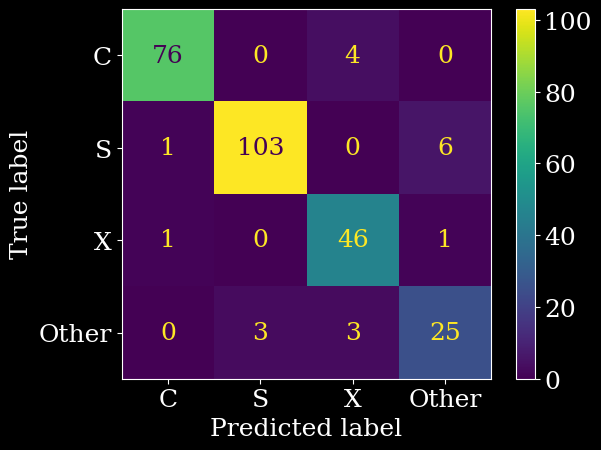

F1 Score: 0.93


In [18]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

# # Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test,
                                          asteroid_classes_test_pred,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")